# Meridional Overturning Circulation

This notebook shows a simple example of calculating the zonally-averaged global meridional overturning circulation, using output from either `MOM5` or `MOM6`. We  compute the overturning circulation both in density-latitude and depth-latitude space.

**Requirements:** The `conda/analysis3-25.06` (or later) module on ARE. We recommend an ARE session with more than 14 cores to make these computations. Ideally, use a whole Gadi compute node from `normal`, i.e., 48 cores.


#### ‼️ ⚠️ 🚨 Caveats 🚨 ⚠️ ‼️
The computations presented in this recipe suffer from _two_ issues in the Arctic ocean region, North of 65ᵒN:

1. The overturning metrics in this notebook do not use correct zonal averaging in the tripole region, north of 65°N! See https://cosima-recipes.readthedocs.io/en/latest/Recipes/True_Zonal_Mean.html for a recipe explainig how to properly average quantities in the zonal direction when the North of 65ᵒN.

2. The notion of vector quantities is distorted North of 65ᵒN. Because North of 65ᵒN the grid cells' local `x`- and `y`- directions do not align with lines of constant latitude and longitude. Thus we need to rotate the volume transports in the local `x`- and `y`-directions to obtain the corresponding transports in the zonal and meridional direction. For that reason, **all computations done in this notebook are wrong North of 65ᵒN**. We do not show anything North of 65ᵒN in any of the plots. See https://github.com/COSIMA/cosima-recipes/issues/510 for more details.


With the above in mind, let's start by loading the requisite libraries:

In [1]:
# import cosima_cookbook as cc
import numpy as np

from dask.distributed import Client

import xarray as xr
import cf_xarray as cfxr
import cf_xarray.units
import pint_xarray
import pint
from pint import application_registry as ureg

import matplotlib.pyplot as plt
import cmocean as cm
import gsw

import intake
cat = intake.cat.access_nri

In [2]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40099,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:42657,Total threads: 1
Dashboard: /proxy/36287/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:41241,


This notebook is designed to use `cf-xarray` and a dictionary of `querying.getvar` arguments to load the correct variables independent of whether you are using a `MOM5` or `MOM6` model. 

Next, choose an experiment. The dictionary below denotes which experiment we want to use for each model.

We can choose experiments at any resolution. For MOM5-based runs, they can be with or without Gent-McWilliams eddy parameterisation.

For this example, we are using 1 year of the 0.1° control simulations. If you want to increase the resolution or integrate over a longer time you might need a bigger ARE session!

In [3]:
model_args = {
    "mom5": {
        "expt": "01deg_jra55v13_ryf9091",
        "frequency": "1mon",
        "variable": "ty_trans_rho",
        "start_time": "2152-01-01",
        "end_time": "2152-12-31",
        "chunks": "auto",
    },
    "mom6": {
        "expt": "OM4_025.JRA_RYF",
        "variable": ["vmo", "rho2_l"],  # Need the data with the density information, not the depth info (y_l)
        "start_time": "1990-01-01",
        "end_time": "1990-12-31",
        "frequency": "1mon",
        "chunks": "auto",
    }
}

setting the dictionary for the remapping function:

In [4]:
remap_args = {
    "mom5": {
        "expt": "01deg_jra55v13_ryf9091",
        "frequency": "1mon",
        "rho_2" : "pot_rho_2",
        "depth" : "st_ocean",
        "latitude_c": "yt_ocean",
        "latitude_b": "yu_ocean",
        "latitude_bsect": "grid_yu_ocean",
        "chunks": "auto",
    },
    "mom6": {
        "expt": "OM4_025.JRA_RYF",
        "frequency": "1mon",
        "rho_2" : "rhopot2",
        "depth" : "z_l",
        "latitude_c": "yh",
        "latitude_b": "yq",
        "latitude_bsect": "yq",
        "chunks": "auto",
    }
}

MOM5: Load up `ty_trans_rho` and sum zonally.
Also, if there is a `ty_trans_rho_gm` variable saved, assume that the [GM parameterisation](https://www2.cgd.ucar.edu/staff/gent/gm20.pdf) is switched on and load that as well, so that the parameterised eddy advection is included. Most ACCESS-OM2 and MOM6 simulations save transport with units of kg/s - convert to Sv.

In [5]:
def load_streamfunction(model):
    expt = model_args[model]["expt"]
    start_time = model_args[model]["start_time"]
    end_time = model_args[model]["end_time"]
    variable = model_args[model]["variable"]
    frequency = model_args[model]["frequency"]

    psi = cat[expt].search(variable=variable, frequency=frequency, require_all_on=["file_id"])
    # require_all_on forces the search to return only datasets with *all* requested variables (MOM6)
    # See https://intake-esm.readthedocs.io/en/v2021.8.17/user-guide/search.html#enforce-query-criteria-via-require-all-on-argument
    psi = psi.to_dask(xarray_open_kwargs={"decode_timedelta": True}).sel(time=slice(start_time, end_time))[
        variable if isinstance(variable, str) else variable[0] # Only want the actual variable treated as such
    ]
    psi = psi.cf.sum("longitude")
    
    psiGM = 0 * psi.copy(deep=True)

    varlist = cat[expt].df["variable"]

    if any(['ty_trans_rho_gm' in _ for _ in varlist]):
        GM = True
        psiGM = cat[expt].search(variable='ty_trans_rho_gm', frequency=frequency).to_dask(xarray_open_kwargs={"decode_timedelta": True}).sel(slice(start_time, end_time))['ty_trans_rho_gm']
        psiGM = psiGM.cf.sum("longitude")
    else:
        GM = False
    
    p0 = 1025 
    
    # convert mass transport -> volume transport and then convert units -> Sv
    psi = (psi / p0) / 1e6
    psiGM = (psiGM / p0) / 1e6
    
    return psi, psiGM, GM

Now, we define a function that cumulatively sums the transport in the vertical. Note that in MOM5 the `ty_trans_rho_GM` variable is computed differently and **does not** require summing in the vertical. Once the calculation has been laid out, we then load the variable to force the computation to occur.

In [6]:
def sum_in_vertical(psi, psiGM, GM):
    psi_avg = psi.cf.cumsum("vertical").mean("time") - psi.cf.sum("vertical").mean("time")
    
    if GM:
        psi_avg = psi_avg + psiGM.cf.mean("time")

    psi_avg.load()

    return psi_avg

Let's load everything from a MOM5 model.

In [7]:
model = 'mom5'
psi, psiGM, GM = load_streamfunction(model)
psi_avg = sum_in_vertical(psi, psiGM, GM)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 79.54 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


## Plotting

Now we are ready to plot. We usually plot the streamfunction over a reduced range of density levels to highlight the deep ocean contribution.

In [8]:
def levels_and_colorbarticks(max_value):
    """ Return the levels and the colorbarticks for the streamfunction plot.
    It may seem complicated but the truth is we just want to avoid the 0 contour
    so that the plot looks soothing to the eye"""

    levels =  np.hstack((np.arange(-max_value, 0, 2), np.flip(-np.arange(-max_value, 0, 2))))
    cbarticks = np.hstack((np.flip(-np.arange(3, max_value, 6)), np.arange(3, max_value, 6)))

    return levels, cbarticks

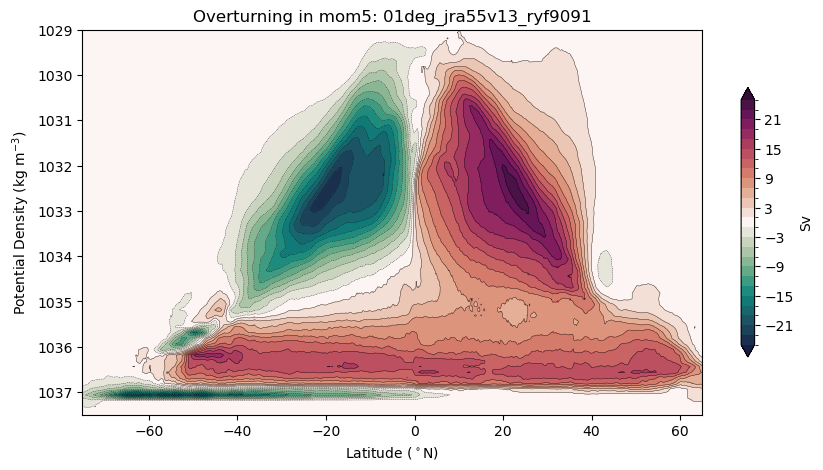

In [9]:
plt.figure(figsize=(10, 5))

max_psi = 25 # Sv

levels, cbarticks = levels_and_colorbarticks(max_psi)

psi_avg.plot.contourf(levels=levels,
                      cmap=cm.cm.curl,
                      extend='both',
                      cbar_kwargs={
                          'shrink': 0.7, 
                          'label': 'Sv', 
                          'ticks': cbarticks
                      })

psi_avg.plot.contour(levels=levels,
                     colors='k',
                     linewidths=0.25)

plt.gca().invert_yaxis()

plt.ylim((1037.5, 1029))
plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75, 65]) # calculations are wrong for region north of 65ᵒN
plt.title(f'Overturning in {model}: {model_args[model]["expt"]}');

Now let's define a function to remap the vertical dimension into depth coordinates.

In [10]:
def remap_depth(remap_args, model_args, psi_avg, model):

    experiment = model_args[model]["expt"]
    start_time = model_args[model]["start_time"]
    end_time = model_args[model]["end_time"]
    variable = remap_args[model]["rho_2"]

    try:
        rho2 = cat[experiment].search(
            variable=remap_args[model]["rho_2"], 
            frequency=remap_args[model]["frequency"],
        ).to_dask(
            xarray_open_kwargs={"decode_timedelta": True}
        )[remap_args[model]["rho_2"]].sel(time=slice(start_time, end_time))
    except ValueError: 
        # The mom6 experiment we picked here doesn't have rho2 saved out - so we
        # are going to reconstruct it using the gsw package. This is a little bit
        # of a hack, but generally should be okay to do in a pinch.
        import warnings
        import gsw
        warnings.warn("No 'rho_2' attribute found - constructing it on the fly using gsw")
        mom6_ts_ds = cat['OM4_025.JRA_RYF'].search(
                variable=["thetao",'so'],
                file_id="XXXXXXXX_ocean_month_z"
        ).to_dask(
            xarray_open_kwargs = {
                "chunks" : "auto",
                "decode_timedelta":False
        })        
        mom6_ts_ds['rho_2'] = gsw.density.sigma0(mom6_ts_ds['so'], mom6_ts_ds['thetao'])
        rho2 = mom6_ts_ds['rho_2'].sel(time=slice(start_time, end_time))
        
    
    #Mask the Mediteranean
    rho2 = rho2.cf.where(((rho2.cf['longitude'] < 0) | (rho2.cf['longitude'] > 45) ) |
                         ((rho2.cf['latitude'] < 10) | (rho2.cf['latitude'] > 48))
                        )

    rho2_time_mean = rho2.mean('time')

    rho2_zonal_mean = rho2_time_mean.cf.mean("longitude").load()
    
    # nmin is the latitude index that corresponds to 78S
    nmin = int(list(
        rho2_zonal_mean.cf['latitude'].values
    ).index(rho2_zonal_mean.cf.sel(latitude=-78, method='nearest').cf['latitude']))

    nmax = np.size(rho2_zonal_mean.cf['latitude'])
        
    psi_depth = 0 * psi_avg.copy(deep=True)
    psi_depth = psi_depth.pint.dequantify()

    for ii in range(nmin, nmax):
        rho1 = rho2_zonal_mean.cf.isel(latitude=ii)
        rho1v = rho1.copy()
        z = rho1.cf['vertical']
        rho1 = rho1.rename({rho1.cf['vertical'].name: 'rho_ref'})
        rho1['rho_ref'] = np.array(rho1v)
        rho1.name = rho2_zonal_mean.cf['vertical'].name
        rho1.values = np.array(z)
        
        rho1 = rho1.isel(rho_ref = ~np.isnan(rho1.rho_ref)).drop_duplicates(dim='rho_ref', keep='first')

        rho1 = rho1.interp(rho_ref = psi_avg.cf['vertical'].values,
                           kwargs={"bounds_error": False, "fill_value": (0, 6000)})
        psi_depth[:, ii] = rho1.rename({'rho_ref': psi_avg.cf['vertical'].name})

    psi_avg2 = psi_avg.rename({remap_args[model]["latitude_bsect"]: 'latitude_b'}) # purely for automatic renaming later

    new_psi_avg = xr.DataArray(data = psi_avg2.values,
                               dims = [remap_args[model]["rho_2"], 'latitude_b'],
                               coords = dict(latitude_b=(["latitude_b"], psi_avg2["latitude_b"].values),
                                             depth=([remap_args[model]["rho_2"], "latitude_b"], psi_depth.values)),
                               attrs = psi_avg.attrs)

    new_psi_avg = new_psi_avg.rename({'latitude_b': remap_args[model]["latitude_b"]})

    
    return psi_depth, new_psi_avg

In [11]:
psi_depth, new_psi_avg = remap_depth(remap_args, model_args, psi_avg, model)
psi_depth

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 80.13 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


<xarray.DataArray 'ty_trans_rho' (potrho: 80, grid_yu_ocean: 2700)> Size: 864kB
array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ..., 6000., 6000., 6000.],
       [   0.,    0.,    0., ..., 6000., 6000., 6000.],
       [   0.,    0.,    0., ..., 6000., 6000., 6000.]], dtype=float32)
Coordinates:
  * potrho         (potrho) float64 640B 1.028e+03 1.028e+03 ... 1.038e+03
  * grid_yu_ocean  (grid_yu_ocean) float64 22kB -81.09 -81.05 ... 89.96 90.0

Text(0.5, 1.0, 'Depth in density coordinates')

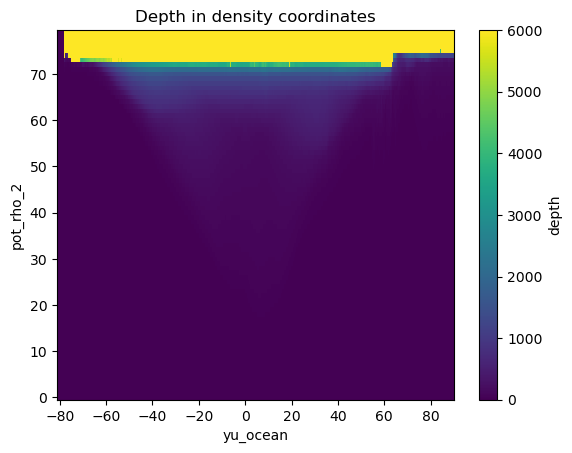

In [12]:
# Let's take a quick look at our mapping back into depth space from density space
new_psi_avg.depth.plot()
plt.gca()
plt.title('Depth in density coordinates')

## Plotting

Let's plot the streamfunction along depth

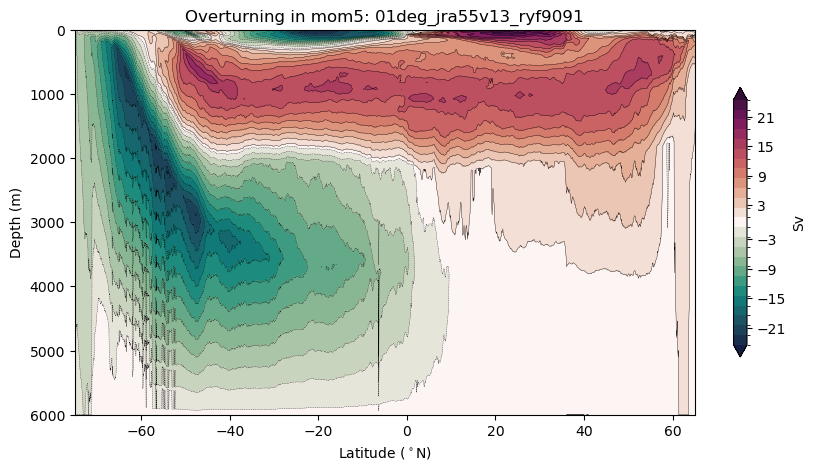

In [13]:
plt.figure(figsize=(10, 5))

max_psi = 24.5 # Sv

levels, cbarticks = levels_and_colorbarticks(max_psi)

new_psi_avg.plot.contourf(y="depth",
                          levels=levels,
                          cmap=cm.cm.curl,
                          extend='both',
                          cbar_kwargs={'shrink': 0.7, 'label': 'Sv', 'ticks': cbarticks})

new_psi_avg.plot.contour(y="depth",
                         levels=levels,
                         colors='k',
                         linewidths=0.25)

plt.gca().invert_yaxis()


plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75, 65]) # calculations are wrong for region north of 65ᵒN
plt.title(f'Overturning in {model}: {model_args[model]["expt"]}');

Now let's do it again using output from a MOM6 model. Easy!

In [14]:
model = 'mom6'
psi, psiGM, GM = load_streamfunction(model)
psi_avg = sum_in_vertical(psi, psiGM, GM)
psi_avg = psi_avg 

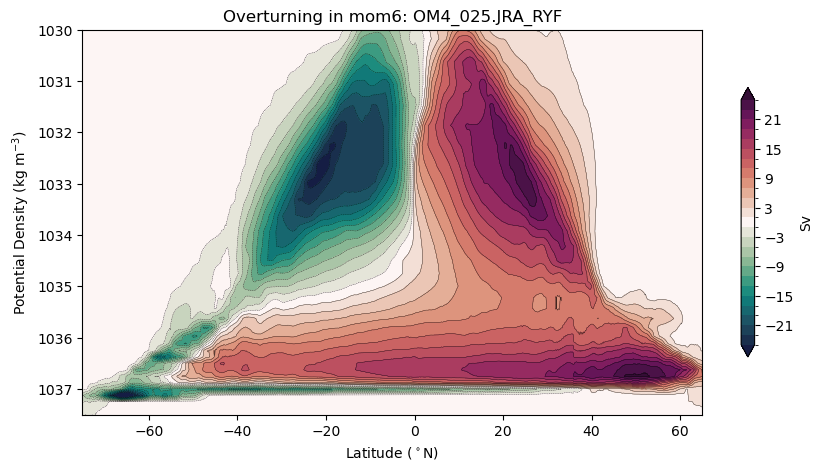

In [15]:
plt.figure(figsize=(10, 5)) 

max_psi = 25 # Sv

levels, cbarticks = levels_and_colorbarticks(max_psi)

psi_avg.plot.contourf(levels=levels,
                      cmap=cm.cm.curl,
                      extend='both',
                      cbar_kwargs={'shrink': 0.7, 
                                   'label': 'Sv', 
                                   'ticks': cbarticks
                                  })

psi_avg.plot.contour(levels=levels,
                     colors='k',
                     linewidths=0.25)

plt.gca().invert_yaxis()

plt.ylim((1037.5, 1030))
plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75, 65]) # calculations are wrong for region north of 65ᵒN
plt.title(f'Overturning in {model}: {model_args[model]["expt"]}');

Alternatively, you may want to stretch your axes to minimise the visual impact of the surface circulation, while showing the full-depth ocean.

In [16]:
stretching_factor = 6 # A power value to set the stretching

ρmin = psi_avg.cf['vertical'].min()

psi_avg_plot = psi_avg.assign_coords(
    {
        psi_avg.cf["vertical"].name: (psi_avg.cf["vertical"] - ρmin)**stretching_factor
    }
)

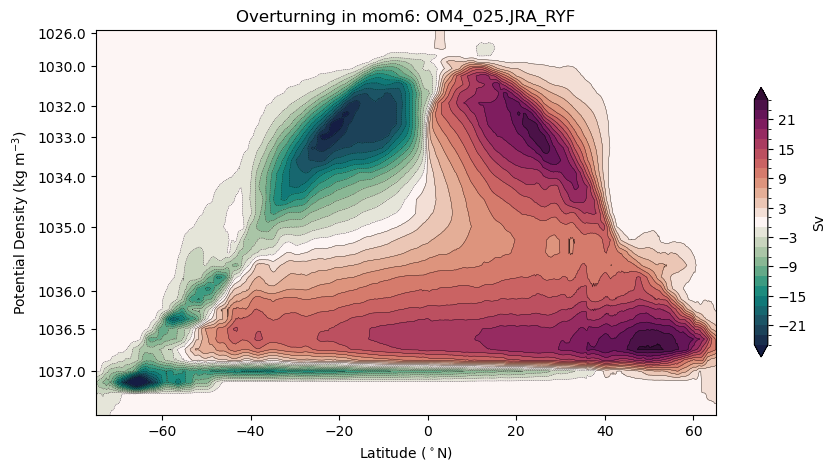

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

max_psi = 25 # Sv

levels, cbarticks = levels_and_colorbarticks(max_psi)

yticks = np.array([1026, 1030, 1032, 1033, 1034, 1035, 1036, 1036.5, 1037])

psi_avg_plot.plot.contourf(levels=levels, 
                           cmap=cm.cm.curl,
                           extend='both',
                           cbar_kwargs={'shrink': 0.7,'label': 'Sv', 'ticks': cbarticks})

psi_avg_plot.plot.contour(levels=levels, colors='k', linewidths=0.25)

plt.gca().set_yticks((yticks - ρmin.values)**stretching_factor)
plt.gca().set_yticklabels(yticks)

# ylims: a bit less than the minimum and a bit more than the maximum values
plt.gca().set_ylim([((yticks - ρmin.values).min() / 1.1)**stretching_factor, ((yticks - ρmin.values).max() * 1.02)**stretching_factor])
plt.gca().invert_yaxis()

plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75, 65]) # calculations are wrong for region north of 65ᵒN
plt.title(f'Overturning in {model}: {model_args[model]["expt"]}');

Remapping the `mom6` streamfunction into depth coordinates.

/jobfs/145405245.gadi-pbs/ipykernel_2168241/3152632245.py:21: UserWarning: No 'rho_2' attribute found - constructing it on the fly using gsw
  warnings.warn("No 'rho_2' attribute found - constructing it on the fly using gsw")


Text(0, 0.5, 'Density Anomaly')

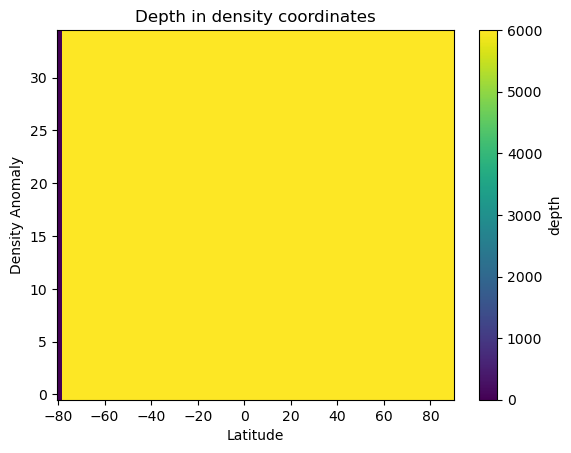

In [18]:
# Currently the depth calculation for the MOM6 streamfunction is incorrect - so we can't 
# regrid to depth coordinates. We can see this when we look at the calculated depths.
# One for the hackathon!
psi_depth, new_psi_avg = remap_depth(remap_args, model_args, psi_avg, model)
new_psi_avg.depth.plot()
plt.gca()
plt.title('Depth in density coordinates')
plt.xlabel('Latitude')
plt.ylabel('Density Anomaly')

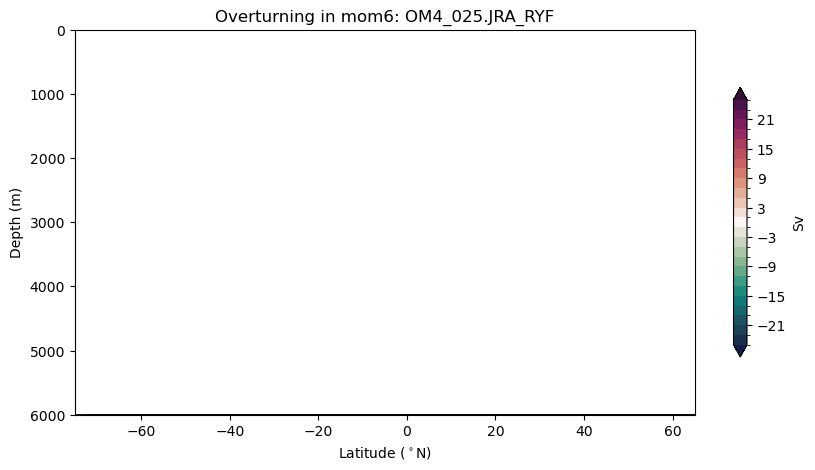

In [19]:
plt.figure(figsize=(10, 5))

max_psi = 25 # Sv

levels, cbarticks = levels_and_colorbarticks(max_psi)

new_psi_avg.plot.contourf(y="depth",
                          levels=levels,
                          cmap=cm.cm.curl,
                          extend='both',
                          cbar_kwargs={'shrink': 0.7, 'label': 'Sv', 'ticks': cbarticks})

new_psi_avg.plot.contour(y="depth",
                         levels=levels,
                         colors='k',
                         linewidths=0.25)

plt.gca().invert_yaxis()

plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75, 65]) # calculations are wrong for region north of 65ᵒN
plt.title(f'Overturning in {model}: {model_args[model]["expt"]}');

- __Note__: This fails because our depth mapping above is incorrect for MOM6, so we are unable to map back into depth coordinates. We need help fixing this!

**Note:**

 * We have not included the [parameterised submesoscale contribution](https://www.sciencedirect.com/science/article/abs/pii/S1463500310001290) to the meridional transport in these calculations, as it tends to be relatively unimportant for the deep circulation, which is where we are primarily interested. To include the parameterised submesoscale contribution in `MOM5`, you would need to use the `ty_trans_submeso` diagnostic.


# Atlantic and Indo-Pacific basin components of the Merodional Overturning Circulation

Here, we compute the zonally averaged Meridional Overturning Streamfunction in density space in a similar fashion to the above, except that we partition the overturning circulation into the Atlantic and Indo-Pacific Basins. Strong North Atlantic deep water circulation in the Atlantic can sometimes obscure Antarctic bottom water circulation in the IndoPacific in global zonally-averaged calculations, something we can minimise by the masking procedure below.

Compute times were calculated using 28 cpus and 124 GB memory Jupyter Lab on gadi, using conda environment analysis3-25.06.

## 2. Create masks for the Atlantic and IndoPacific Basins

Here we want to create two masks; one that masks for the Southern Ocean south of 33S (around the bottom of Africa) and the Atlantic Ocean, and one that masks for the Southern Ocean south of 33S and the Indian plus Pacific Oceans.

A bit of fiddling is a little unavoidable here but the procedure below should be compatible with 0.25$^\circ$ or 1$^\circ$ grid data so you don't have to repeat the whole process.

In [20]:
experiment = '025deg_jra55_ryf9091_gadi'

start_time = '1900-01-01'
end_time = '1903-12-31'

To start with, load the bathymetry from the experiment of interest.

In [21]:
ht = cat[experiment].search(variable="ht").to_dask(
    xarray_open_kwargs={"use_cftime": True})["ht"]
ht

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/source.py:280: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


<xarray.DataArray 'ht' (yt_ocean: 1080, xt_ocean: 1440)> Size: 6MB
dask.array<open_dataset-ht, shape=(1080, 1440), dtype=float32, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
    geolon_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(540, 720), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(540, 720), meta=np.ndarray>
Attributes:
    long_name:      ocean depth on t-cells
    units:          m
    valid_range:    [-1.e+09  1.e+09]
    cell_methods:   time: point
    standard_name:  sea_floor_depth_below_geoid

Now, make a `land_mask`. This is just a dataarray with `1`'s where you have ocean and `0`'s where you have land. We are going to work with this mask to delineate the different ocean basins.

In [22]:
land_mask = ~ht.isnull()

Now, let's draw in a set of meridians that lie within land masses separating the Atlantic basin from the Indo-Pacific basins, to show where our mask is going to go. We will also have a line to delineate the southern boundary.

Note that the problems with this mask are:
* It is not perfect at the Panama Canal; 
* The Great Australian Bight is not counted in the Southern Ocean; 
* The calculation is done on T points, but streamfunction is actually found on the (`xt_ocean`,`yu_ocean`) grid; and
* We have ignored the tripole, so zonal averages north of 65°N are not so meaningful. That is of no consequence for the Pacific, but more relevant for the Atlantic/Arctic sector.

These are all pretty minor issues for a global quantity like the overturning, but users should feel free to improve this if they like.

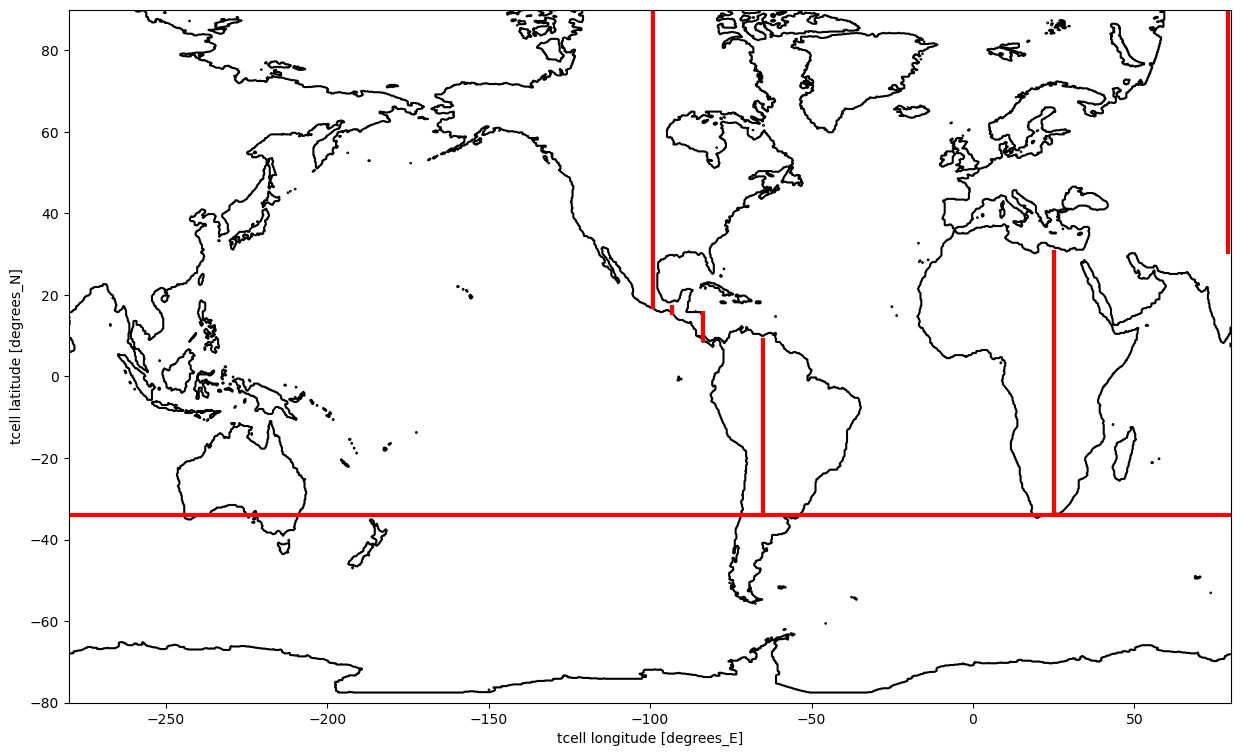

In [23]:
fig=plt.figure(2, (15, 9))
ax = plt.subplot()

land_mask.plot.contour(levels=[0.5], colors='k')

ax.plot([-280, 80], [-34,-34], 'r', linewidth = 3)
ax.plot([-65, -65], [-34, 9], 'r', linewidth = 3)
ax.plot([-83.7, -83.7], [9, 15.5], 'r', linewidth = 3)
ax.plot([-93.3, -93.3], [15.5, 17], 'r', linewidth = 3)
ax.plot([-99, -99], [17, 90], 'r', linewidth = 3)
ax.plot([25, 25], [-34,30.5], 'r', linewidth = 3)
ax.plot([79, 79], [30.5, 90], 'r', linewidth = 3)

ax.set_xlim([-280, 80])
ax.set_ylim([-80, 90]);

Now, let's make our masks along these dividing lines. Note that we include the Southern Ocean in both the Atlantic and the Indo-Pacific masks.

In [24]:
## create masks out of the above chunks
south_map = (land_mask.where(land_mask.yt_ocean < -34)).fillna(0)
indo_map1 = (land_mask.where(land_mask.yt_ocean < 9).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean > -280).where(land_mask.xt_ocean < -65)).fillna(0)
indo_map2 = (land_mask.where(land_mask.yt_ocean < 15).where(land_mask.yt_ocean > 9).where(land_mask.xt_ocean > -280).where(land_mask.xt_ocean < -83.7)).fillna(0)
indo_map3 = (land_mask.where(land_mask.yt_ocean < 17).where(land_mask.yt_ocean > 15).where(land_mask.xt_ocean > -280).where(land_mask.xt_ocean < -93.3)).fillna(0)
indo_map4 = (land_mask.where(land_mask.yt_ocean < 85).where(land_mask.yt_ocean > 17).where(land_mask.xt_ocean > -280).where(land_mask.xt_ocean < -99)).fillna(0)
indo_map5 = (land_mask.where(land_mask.yt_ocean < 30.5).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean > 25).where(land_mask.xt_ocean < 80)).fillna(0)

indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
indo_sector_mask = indo_sector_map.where(indo_sector_map>0)

atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
atlantic_sector_map = atlantic_sector_map + south_map
atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map > 0)
atlantic_sector_mask

<xarray.DataArray 'ht' (yt_ocean: 1080, xt_ocean: 1440)> Size: 12MB
dask.array<where, shape=(1080, 1440), dtype=float64, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
    geolon_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(540, 720), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(540, 720), meta=np.ndarray>

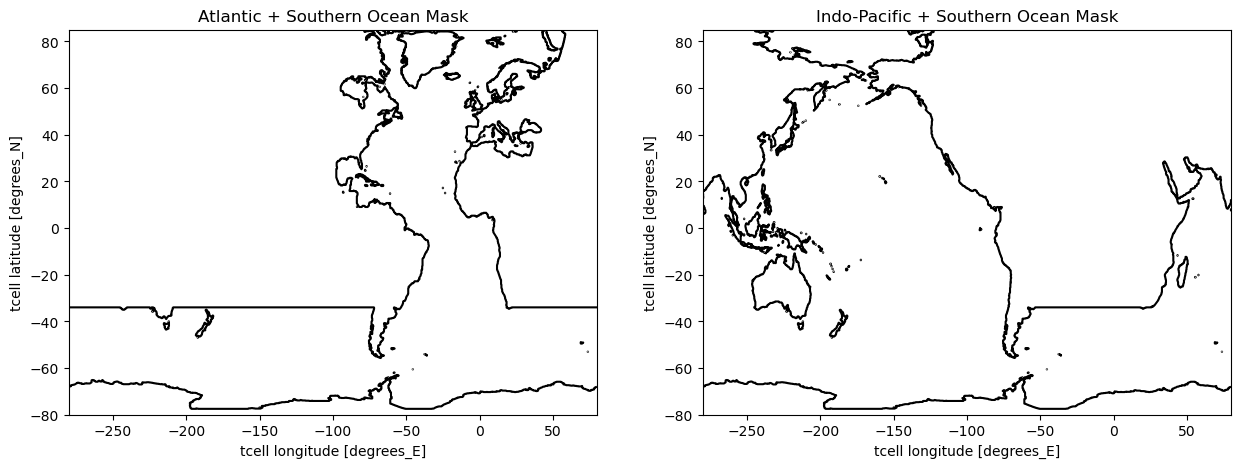

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

atlantic_sector_map.plot.contour(ax=ax[0], levels=[0.5], colors='k')
ax[0].set_xlim([-280, 80])
ax[0].set_ylim([-80, 85])
ax[0].set_title('Atlantic + Southern Ocean Mask')

indo_sector_map.plot.contour(ax=ax[1], levels=[0.5], colors='k')
ax[1].set_xlim([-280, 80])
ax[1].set_ylim([-80, 85])
ax[1].set_title('Indo-Pacific + Southern Ocean Mask');

## 3. Mask `ty_trans_rho` by the basins and compute basin MOC

The mask above is on a different grid `(yt_ocean, xt_ocean)` to `ty_trans_rho`, which uses `(grid_yu_ocean, grid_xt_ocean)`, so we'll need to alter that. This is done coarsely but we dont need a super perfect mask for this diagnostic. To do this, just load the a single frame of `ty_trans_rho` and replace the coordinate names and/or values as appropriate.


In [26]:
psi = cat[experiment].search(variable="ty_trans_rho", frequency="1mon").to_dask(
    xarray_open_kwargs={"use_cftime": True, "decode_timedelta": False}
).isel(time=0) ## needs to be the same coordinates as what you want to mask
psi

<xarray.Dataset> Size: 498MB
Dimensions:        (potrho: 80, grid_yu_ocean: 1080, grid_xt_ocean: 1440)
Coordinates:
    time           object 8B 1900-01-16 12:00:00
  * grid_xt_ocean  (grid_xt_ocean) float64 12kB -279.9 -279.6 ... 79.62 79.88
  * grid_yu_ocean  (grid_yu_ocean) float64 9kB -81.02 -80.92 ... 89.89 90.0
  * potrho         (potrho) float64 640B 1.028e+03 1.028e+03 ... 1.038e+03
Data variables:
    ty_trans_rho   (potrho, grid_yu_ocean, grid_xt_ocean) float32 498MB dask.array<chunksize=(14, 216, 288), meta=np.ndarray>
Attributes: (12/16)
    filename:                                 ocean.nc
    title:                                    ACCESS-OM2-025
    grid_type:                                mosaic
    grid_tile:                                1
    intake_esm_vars:                          ['ty_trans_rho']
    intake_esm_attrs:filename:                ocean.nc
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,sea_water_conserv...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,,,,time: mean,time: ...
    intake_esm_attrs:variable_units:          degrees_E,degrees_N,meters,mete...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean.1mon

In [27]:
atlantic_sector_mask = atlantic_sector_mask.rename(
    {'xt_ocean': 'grid_xt_ocean', 'yt_ocean': 'grid_yu_ocean'}
).assign_coords(
    grid_yu_ocean=("grid_yu_ocean", psi["grid_yu_ocean"].data)
)

indo_sector_mask = indo_sector_mask.rename(
    {'xt_ocean': 'grid_xt_ocean', 'yt_ocean': 'grid_yu_ocean'}
).assign_coords(
    grid_yu_ocean=("grid_yu_ocean", psi["grid_yu_ocean"].data)
)

In [28]:
atlantic_sector_mask

<xarray.DataArray 'ht' (grid_yu_ocean: 1080, grid_xt_ocean: 1440)> Size: 12MB
dask.array<where, shape=(1080, 1440), dtype=float64, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
  * grid_xt_ocean  (grid_xt_ocean) float64 12kB -279.9 -279.6 ... 79.62 79.88
    geolon_t       (grid_yu_ocean, grid_xt_ocean) float32 6MB dask.array<chunksize=(540, 720), meta=np.ndarray>
    geolat_t       (grid_yu_ocean, grid_xt_ocean) float32 6MB dask.array<chunksize=(540, 720), meta=np.ndarray>
  * grid_yu_ocean  (grid_yu_ocean) float64 9kB -81.02 -80.92 ... 89.89 90.0

Now write a function which calculates the time-averaged overturning circulation for a particular `basin_mask`. This function allows us to limit the time of the calculation using either `nbound` or `start_time` and `end_time`.

In [29]:
def compute_basin_psi_rho(experiment, basin_mask, 
                          nbound=None, start_time=None, end_time=None):
    ρ0 = 1025 # mean density of sea-water in kg/m^3
    
    varlist = []
    for varlist_ind in cat[experiment].df["variable"]:
        for v in varlist_ind:
            if v not in varlist:
                varlist.append(v)
    if "ty_trans_rho_gm" in varlist:
        GM = True
        print('GM is True')
        psiGM = cat[experiment].search(variable="ty_trans_rho_gm", frequency="1mon").to_dask(xarray_open_kwargs={
            "use_cftime": True, "decode_timedelta": True,}).sel(time=slice(start_time, end_time))
        if nbound is not None:
            psiGM = psiGM.isel(time=slice(1,nbound))
        psiGM = psiGM["ty_trans_rho_gm"]
        psiGM = psiGM.sum('grid_xt_ocean')
        psiGM = psiGM / (1e6 * ρ0) # converts kg/s to Sv
    else:
        GM = False
        print('GM is False')
        
    psi = cat[experiment].search(variable="ty_trans_rho", frequency="1mon").to_dask(xarray_open_kwargs={
        "use_cftime": True, "decode_timedelta": True,
    }).sel(time=slice(start_time, end_time))["ty_trans_rho"]
    psi = psi / (1e6 * ρ0) # converts kg/s to Sv
    psi = (psi * basin_mask).sum('grid_xt_ocean').cumsum('potrho').mean(dim='time')
    psi = psi.load()
    if GM:
        psi = psi + psiGM.mean('time')
        
    return psi

Now compute the basin-averaged, time-mean overturning for each basin.

**Note**: The following two cells might take a few minutes.

In [30]:
%%time
atlantic_psi = compute_basin_psi_rho(experiment, atlantic_sector_mask, start_time=start_time, end_time=end_time)
atlantic_psi

GM is False


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.77 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 1min 10s, sys: 13.6 s, total: 1min 24s
Wall time: 1min 24s


<xarray.DataArray (potrho: 80, grid_yu_ocean: 1080)> Size: 691kB
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -7.74514063e-03, -9.65788374e-03, -8.78101507e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -7.94098186e-03, -9.38408384e-03, -8.78106349e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.27252944e-03, -9.74821145e-03, -8.79068175e-03],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -7.77186256e-03, -4.12597557e-03, -2.39407845e-08],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -7.77186256e-03, -4.12597557e-03, -2.39407845e-08],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -7.77186256e-03, -4.12597557e-03, -2.39407845e-08]])
Coordinates:
  * grid_yu_ocean  (grid_yu_ocean) float64 9kB -81.02 -80.92 ... 89.89 90.0
  * potrho         (potrho) float64 640B 1.028e+03 1.028e+03 ... 1.038e+03

In [31]:
%%time
indopacific_psi = compute_basin_psi_rho(experiment, indo_sector_mask, start_time=start_time, end_time=end_time)
indopacific_psi

GM is False


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.76 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 1min 9s, sys: 12.2 s, total: 1min 21s
Wall time: 1min 22s


<xarray.DataArray (potrho: 80, grid_yu_ocean: 1080)> Size: 691kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * grid_yu_ocean  (grid_yu_ocean) float64 9kB -81.02 -80.92 ... 89.89 90.0
  * potrho         (potrho) float64 640B 1.028e+03 1.028e+03 ... 1.038e+03

## 4. Plotting

Now plot the output. We have chosen to do these plots with a distorted `y`-axis, so that we can see the densest water masses.

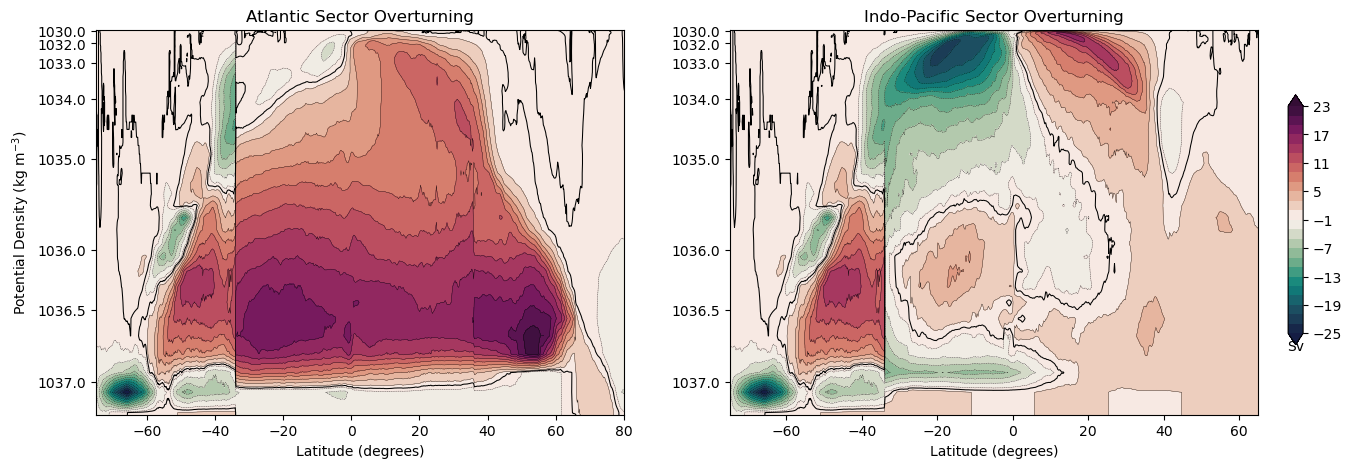

In [32]:
clev=np.arange(-25, 25, 2)
yticks = np.array([1030, 1032, 1033, 1034, 1035, 1036, 1036.5, 1037])
scfac = 4  ## A power to set the stretching of the y-axis

fig, ax=plt.subplots(1, 2, figsize=(15, 5))

## Plotting Atlantic Sector
ax[0].contourf(atlantic_psi.grid_yu_ocean, (atlantic_psi.potrho - 1028)**scfac, atlantic_psi,
               cmap=cm.cm.curl, levels=clev, extend='both')
ax[0].contour(atlantic_psi.grid_yu_ocean, (atlantic_psi.potrho - 1028)**scfac, atlantic_psi,
              levels=clev, colors='k', linewidths=0.25)
ax[0].contour(atlantic_psi.grid_yu_ocean, (atlantic_psi.potrho - 1028)**scfac, atlantic_psi,
              levels=[0.0,], colors='k', linewidths=0.75)

ax[0].set_yticks((yticks - 1028)**scfac)
ax[0].set_yticklabels(yticks)
ax[0].set_ylim([0.5**scfac, 9.2**scfac])
ax[0].invert_yaxis()
ax[0].set_ylabel('Potential Density (kg m$^{-3}$)')
ax[0].set_xlabel('Latitude (degrees)')
ax[0].set_xlim([-75, 80])
ax[0].set_title('Atlantic Sector Overturning')


## Plotting Indo-Pacific Sector
p=ax[1].contourf(indopacific_psi.grid_yu_ocean, (indopacific_psi.potrho - 1028)**scfac, indopacific_psi,
                 cmap=cm.cm.curl, levels=clev, extend='both')
ax[1].contour(indopacific_psi.grid_yu_ocean, (indopacific_psi.potrho - 1028)**scfac, indopacific_psi,
              levels=clev, colors='k', linewidths=0.25)
ax[1].contour(indopacific_psi.grid_yu_ocean, (indopacific_psi.potrho - 1028)**scfac, indopacific_psi,
              levels=[0.0,], colors='k', linewidths=0.75)

ax[1].set_yticks((yticks - 1028)**scfac)
ax[1].set_yticklabels(yticks)
ax[1].set_ylim([0.5**scfac, 9.2**scfac])
ax[1].invert_yaxis()
ax[1].set_xlabel('Latitude (degrees)')
ax[1].set_xlim([-75, 65])
ax[1].set_title('Indo-Pacific Sector Overturning');

# Plot a colorbar
cax = plt.axes([0.92, 0.25, 0.01, 0.5])
cb=plt.colorbar(p, cax=cax, orientation='vertical')
cb.ax.set_xlabel('Sv');

These plots compare pretty favourably with the ECCO4 reanalysis overturning cells (see figure 2 by [Cessi, 2019](https://www.annualreviews.org/doi/full/10.1146/annurev-marine-010318-095241)). We believe that they contribute to the intuition compared to the globally zonal-averaged picture of the overturning.